I'm curious what the HOD parameters I recover from SHAM (and UM) in a cosmological context. Similarly, do the Assembly bias values I recover make sense? 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from os import path
import h5py
import astropy
from scipy.special import erf
from halotools.mock_observables import hod_from_mock
from halotools.utils import broadcast_host_halo_property, add_halo_hostid

In [3]:
from pearce.mocks.kittens import TrainingBox, TestBox

In [4]:
#um_dir = '/u/ki/swmclau2/des/aemulus_mock_catalogs/'
um_dir = '/home/users/swmclau2/scratch/UniverseMachine/'

In [5]:
cen_hod = np.load(path.join(um_dir,'mdpl2_cen_hod.npy'))
sat_hod = np.load(path.join(um_dir,'mdpl2_sat_hod.npy'))
tot_hod = np.load(path.join(um_dir,'mdpl2_hod.npy'))

In [6]:
mass_func = np.load(path.join(um_dir, 'mass_function.npy'))

In [7]:
haloprop_bins = np.logspace(10,16, 60)
mbc = (haloprop_bins[1:]+haloprop_bins[:-1])/2.0

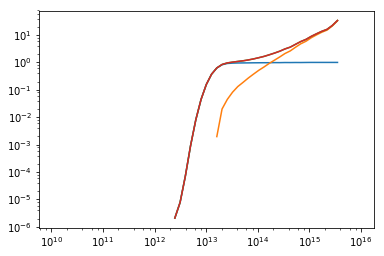

In [8]:
plt.plot(mbc, cen_hod)
plt.plot(mbc, sat_hod)
plt.plot(mbc, cen_hod+sat_hod)
plt.plot(mbc, tot_hod)
plt.loglog();

In [9]:
def ZhengCenHOD(mass, param_dict):
    
    logM = np.log10(mass)
    mean_ncen = 0.5*(1.0 + erf(
        (logM - param_dict['logMmin']) / param_dict['sigma_logM']))

    return mean_ncen

def ZhengSatHOD(mass, param_dict, mean_ncen = None):
    M0 = 10.**param_dict['logM0']
    M1 = 10.**param_dict['logM1']

    mean_nsat = np.zeros_like(mass)

    idx_nonzero = np.where(mass - M0 > 0)[0]
    
    mean_nsat[idx_nonzero] = ((mass[idx_nonzero] - M0)/M1)**param_dict['alpha']

    # If a central occupation model was passed to the constructor,
    # multiply mean_nsat by an overall factor of mean_ncen
    if mean_ncen is not None:
        # compatible with AB models
        mean_nsat *= mean_ncen

    return mean_nsat

def ZhengHOD(mass, param_dict):
    mean_ncen = ZhengCenHOD(mass, param_dict)
    mean_nsat = ZhengSatHOD(mass, param_dict, mean_ncen)
    return mean_ncen, mean_nsat

In [10]:
def calc_nd(mass,param_dict, mass_func):
    cen_hod, sat_hod = ZhengHOD(mass, param_dict)
    hod = cen_hod+sat_hod
    return np.dot(mass_func, hod)/(1000.0**3)

from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, mass, mass_func):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (calc_nd(mass, hod_params, mass_func) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [11]:
with h5py.File('/home/users/swmclau2/scratch/PearceMCMC/HOD_MDPL2_wp_ds_rmin_0.5_HOD.hdf5', 'r') as f:
    hod_pnames =  f.attrs['param_names'][7:-1]
    chain = f['chain'][:, 7:-1]

In [12]:
param_dict = dict(zip(hod_pnames, chain[0]))

In [13]:
add_logMmin(param_dict, mbc, mass_func)

In [14]:
true_hod_params = {'alpha': 1.083, 'logM0': 13.2, 'logM1': 14.2, 'sigma_logM': 0.2}
true_hod_params['logMmin'] = 13.0 #approx, can fit if i have to

In [15]:
cat = TrainingBox(11)#34)#25)
#cat = TestBox(1,1)
cat.load(1.0, HOD='zheng07', particles=True)

most_recent_11_particle_2.00


In [16]:
def add_logMmin2(cat, params, nd):
    def func(logMmin, hod_params):
        params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(params, min_ptcl=20) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (params,), options = {'maxiter':100}, method = 'Bounded')

     # assuming this doens't fail
    #print 'logMmin', res.x
    params['logMmin'] = res.x


In [17]:
add_logMmin2(cat, true_hod_params, 5e-4)
cat.populate(true_hod_params, min_ptcl = 20)

In [18]:
np.sum(mass_func*cen_hod)/(1000.0**3)

0.00038746199999999998

In [19]:
np.sum(mass_func*sat_hod)/(1000.0**3)

7.0133000000000001e-05

In [20]:
np.sum(mass_func*(cen_hod+sat_hod))/(1000.0**3)

0.00045759499999999999

**********


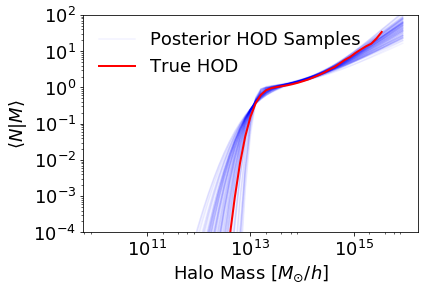

In [21]:
N = 100
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(6,4))
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for ino, i in enumerate(idxs):
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    if ino == 0:
        plt.plot(mbc, c+s, alpha = 0.05, color = 'b', label = 'Posterior HOD Samples')

    else:
        plt.plot(mbc, c+s, alpha = 0.05, color = 'b')
    
plt.plot(mbc, tot_hod, color = 'r', lw =2, label = 'True HOD')
print '*'*10
#add_logMmin(param)
#c,s = ZhengHOD(mbc, true_hod_params)
#plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.legend(loc=2, frameon=False)
#plt.title('HOD Posterior Samples')
plt.ylim([1e-4, 1e2])
plt.xlabel(r'Halo Mass [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N | M \rangle$')

**********


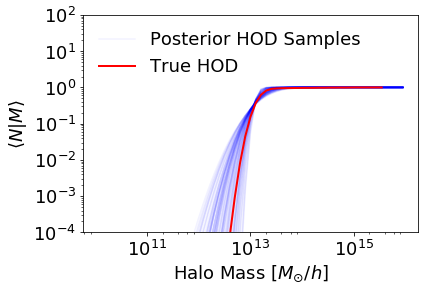

In [22]:
N = 100
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(6,4))
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for ino, i in enumerate(idxs):
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    if ino == 0:
        plt.plot(mbc, c, alpha = 0.05, color = 'b', label = 'Posterior HOD Samples')

    else:
        plt.plot(mbc, c, alpha = 0.05, color = 'b')
    
plt.plot(mbc, cen_hod, color = 'r', lw =2, label = 'True HOD')
print '*'*10
#add_logMmin(param)
#c,s = ZhengHOD(mbc, true_hod_params)
#plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.legend(loc=2, frameon=False)
#plt.title('HOD Posterior Samples')
plt.ylim([1e-4, 1e2])
plt.xlabel(r'Halo Mass [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N | M \rangle$')

**********


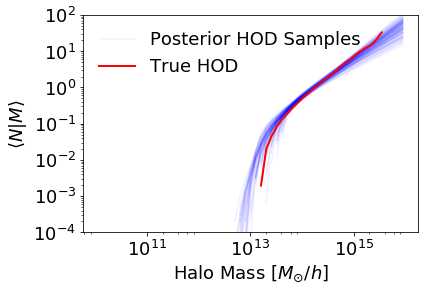

In [23]:
N = 100
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(6,4))
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for ino, i in enumerate(idxs):
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    if ino == 0:
        plt.plot(mbc, s, alpha = 0.05, color = 'b', label = 'Posterior HOD Samples')

    else:
        plt.plot(mbc, s, alpha = 0.05, color = 'b')
    
plt.plot(mbc, sat_hod, color = 'r', lw =2, label = 'True HOD')
print '*'*10
#add_logMmin(param)
#c,s = ZhengHOD(mbc, true_hod_params)
#plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.legend(loc=2, frameon=False)
#plt.title('HOD Posterior Samples')
plt.ylim([1e-4, 1e2])
plt.xlabel(r'Halo Mass [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N | M \rangle$')

In [24]:
catalog = np.load(path.join(um_dir,'hod_catalog5.npy'), allow_pickle=True )

In [25]:
mdpl2_sat_mask = catalog['gal_type']== 'satellites'# == 'satellites'

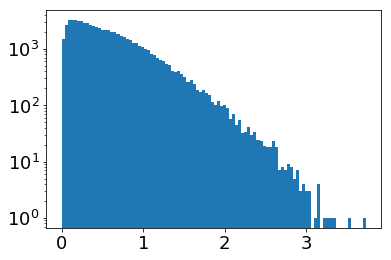

In [26]:
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = 100);
plt.yscale('log')

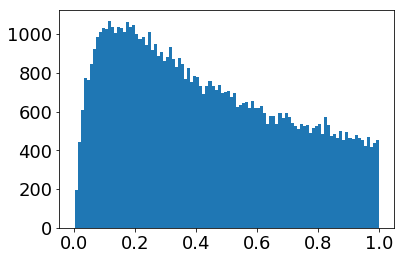

In [27]:
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance']/catalog[mdpl2_sat_mask]['halo_rvir'], bins = 100);
#plt.yscale('log')

In [28]:
gal_table = cat.model.mock.galaxy_table
sat_mask= gal_table['gal_type'] == 'satellites'

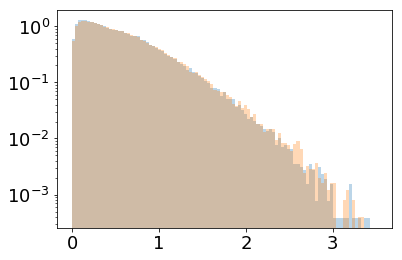

In [29]:
bins = np.linspace(0, 3.5, 100)
plt.hist(gal_table[sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);
plt.yscale('log')

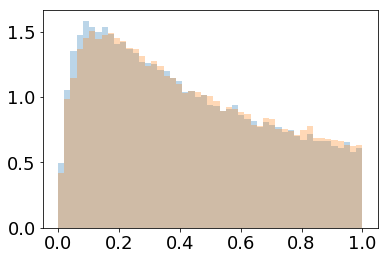

In [30]:
bins = np.linspace(0, 1, 50)
plt.hist(gal_table[sat_mask]['host_centric_distance']/gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True);
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance']/catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True);


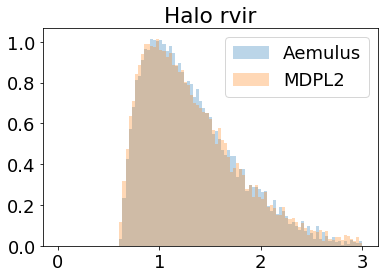

In [31]:
bins = np.linspace(0,3, 100)
plt.hist(gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(1.0*catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.title('Halo rvir')

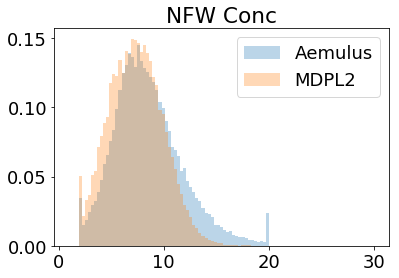

In [32]:
bins = np.linspace(1, 30, 100)
plt.hist(gal_table[sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(1.0*catalog[mdpl2_sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.title('NFW Conc')

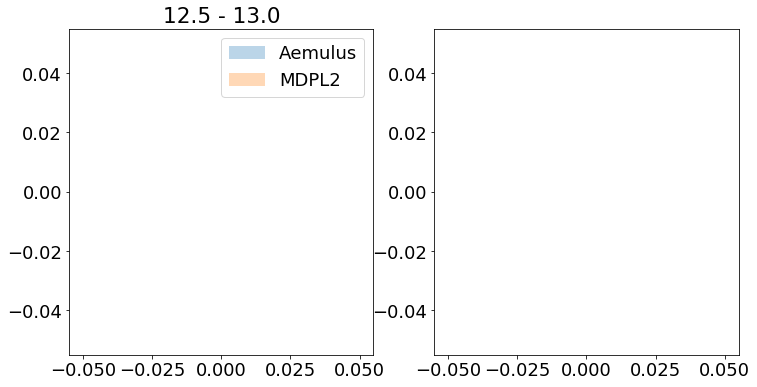

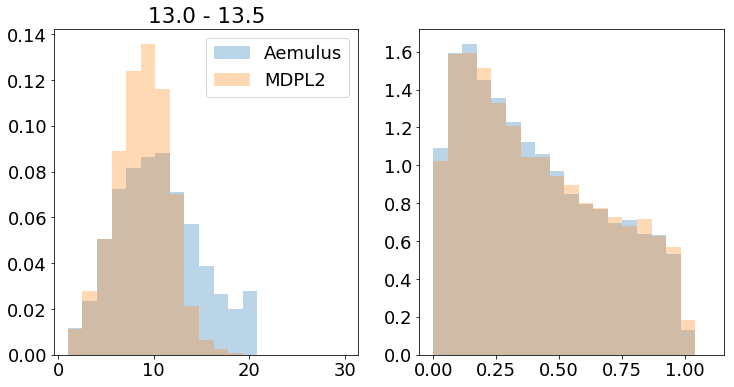

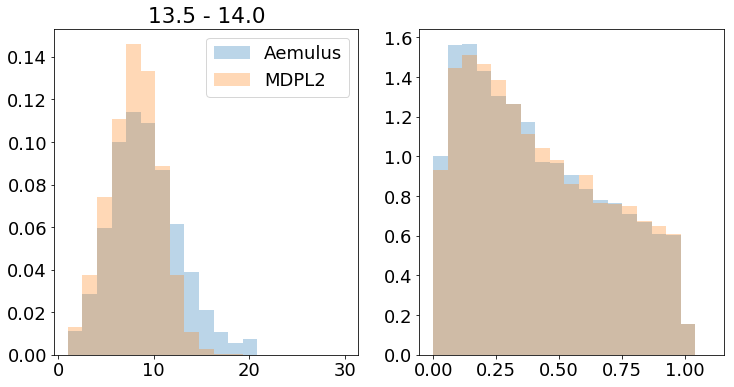

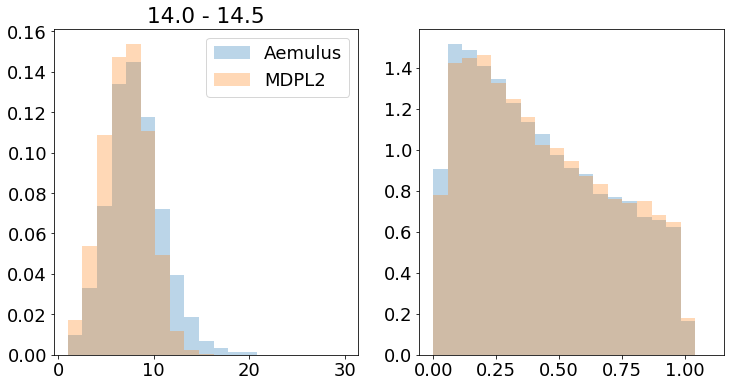

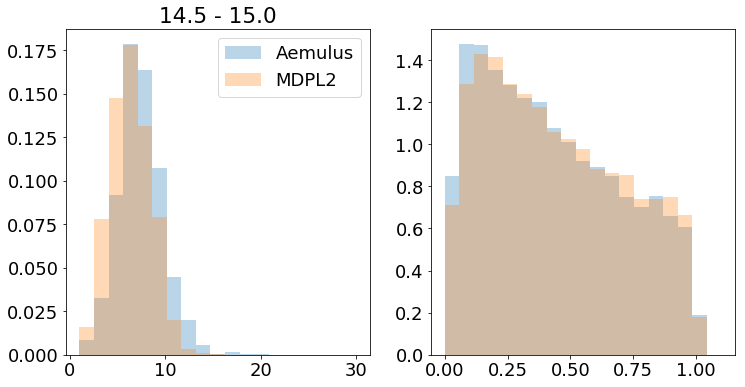

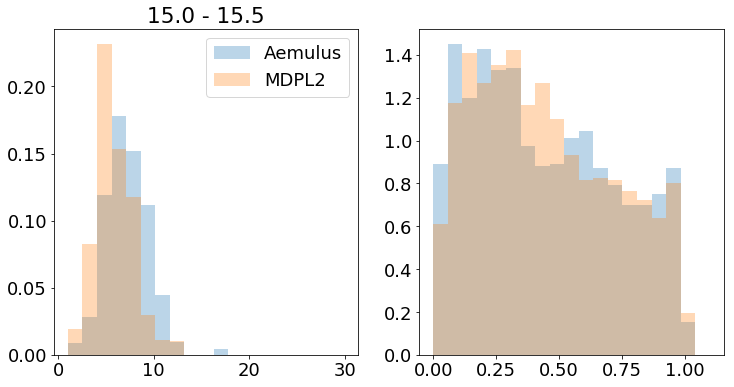

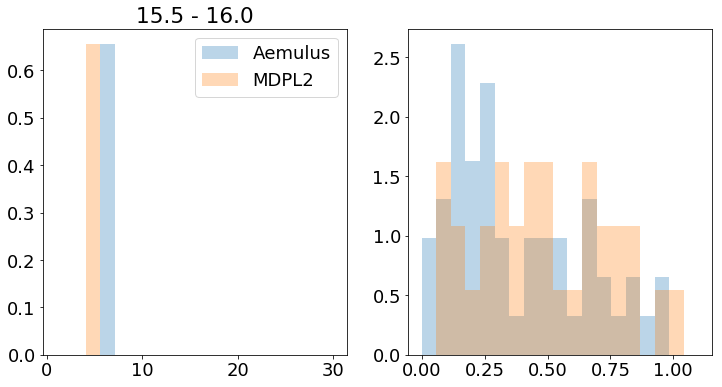

In [33]:
cbins = np.linspace(1, 30, 20)
rbins = np.linspace(0, 1.1, 20)

haloprop_bins = np.logspace(12.5,16,8)

for i,(mbl, mbh) in enumerate(zip(haloprop_bins[:-1], haloprop_bins[1:])):
    fig = plt.figure(figsize=(12,6))
    mass_cut = np.logical_and(mbl<gal_table['halo_mvir'], gal_table['halo_mvir']<mbh)
    mask = np.logical_and(mass_cut, sat_mask)
    plt.subplot(121)
    plt.hist(gal_table[mask]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'Aemulus');
    
    mass_cut = np.logical_and(mbl<catalog['halo_mvir'], catalog['halo_mvir']<mbh)
    mask2 = np.logical_and(mass_cut, mdpl2_sat_mask)
    plt.hist(1.0*catalog[mask2]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'MDPL2');
    plt.title('%0.1f - %0.1f'%(np.log10(mbl),np.log10(mbh)))
    plt.legend(loc='best')
    plt.subplot(122)
    plt.hist(gal_table[mask]['host_centric_distance']/gal_table[mask]['halo_rvir'], bins = rbins, alpha = 0.3, normed=True);
    plt.hist(catalog[mask2]['host_centric_distance']/catalog[mask2]['halo_rvir'], bins = rbins, alpha = 0.3, normed=True);

    plt.show()

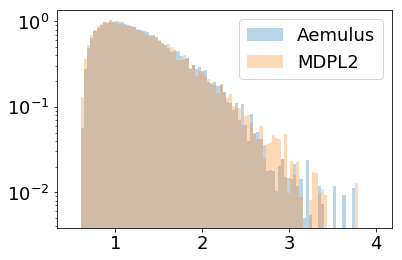

In [34]:
bins = np.linspace(0.5, 4, 100)
plt.hist(gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.yscale('log')

Is low mass occupation different? 

In [35]:
haloprop_bins = np.logspace(10,16, 60)
mbc = (haloprop_bins[1:]+haloprop_bins[:-1])/2.0

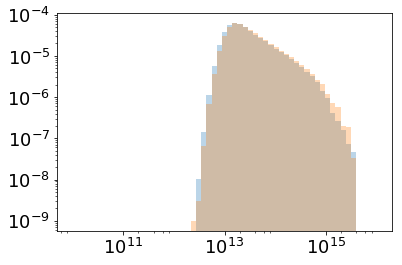

In [36]:
plt.hist(gal_table['halo_mvir'], \
         weights = np.ones_like(gal_table['halo_mvir'])/cat.Lbox**3, bins =haloprop_bins, alpha = 0.3)
plt.hist(catalog['halo_mvir'],\
         weights = np.ones_like(catalog['halo_mvir'])/(1000.0**3),\
                                bins = haloprop_bins, alpha = 0.3)
plt.xscale('log')
plt.yscale('log')

In [37]:
len(gal_table)/(cat.Lbox**3)

0.0005007511067919231

In [38]:
len(catalog)/(1000.0**3)

0.000500041

In [39]:
np.min(gal_table['halo_mvir'])/cat.pmass

91.999758821295416

In [40]:
cat.pmass

33579435106.311516

In [71]:
mdpl2_wp = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD5mock_ds.npy')

In [72]:
hod_wp = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_ds.npy')

In [73]:
rbc = (bins[1:]+bins[:-1])/2.0

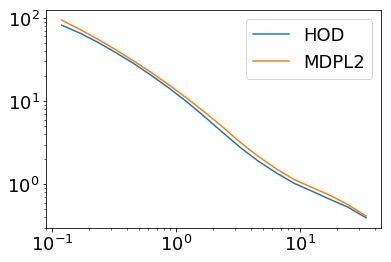

In [74]:
plt.plot(rbc, hod_wp, label = 'HOD')
plt.plot(rbc, mdpl2_wp, label = 'MDPL2')

plt.legend(loc='best')
plt.loglog();

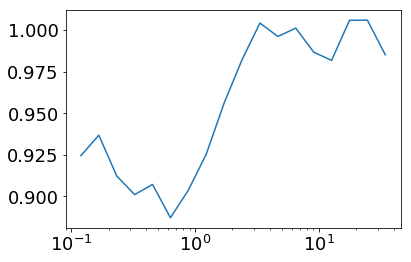

In [70]:
#plt.plot(rbc, hod_wp)
plt.plot(rbc, hod_wp/mdpl2_wp)

plt.xscale('log');

In [48]:
Om = (cat.cosmo_params['omch2']+cat.cosmo_params['ombh2'])/((cat.cosmo_params['H0']/100.0)**2)
S8 = cat.cosmo_params['sigma8']*np.sqrt(Om/0.3)
H0 = cat.cosmo_params['H0']

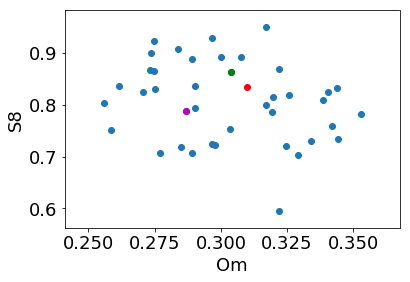

In [49]:
plt.scatter(Om, S8)
plt.scatter(0.31, 0.835,  color = 'r')
plt.scatter(Om[34], S8[34], color = 'g')
plt.scatter(Om[11], S8[11], color = 'm')

plt.xlabel('Om')
plt.ylabel('S8')

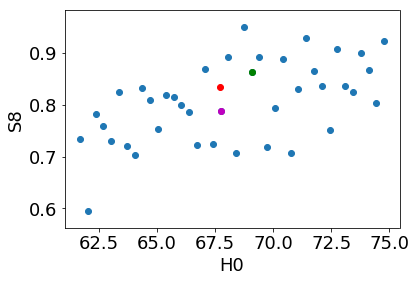

In [50]:
plt.scatter(H0, S8)
plt.scatter(67.7, 0.835,  color = 'r')
plt.scatter(H0[34], S8[34], color = 'g')
plt.scatter(H0[11], S8[11], color = 'm')

plt.xlabel('H0')
plt.ylabel('S8')

In [51]:
key_params = np.c_[Om, S8, H0]

In [52]:
np.argsort(np.sum( ((key_params - np.array([[0.31, 0.835, 67.7]]))**2)/np.array([[0.31, 0.835, 67.7]]), axis = 1))

array([11, 22, 20, 27, 32, 21, 34, 37, 14, 33,  8, 25, 38, 12, 16,  4, 36,
       39, 18,  7, 13, 29,  3, 26,  2,  0, 10, 24, 19,  6,  5,  9,  1, 30,
       23, 35, 31, 15, 17, 28])

In [53]:
closest_cosmo

NameError: name 'closest_cosmo' is not defined

In [ ]:
plt.hist(S8)